Police crime data for San Francisco can be obtained from: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783

The strategy for data processing and features:

1. Select: Incident Date, Incident Category

2. Handling Missing Values:
For Incident Category rows with missing values will be dropped

3. Data Transformation:
Incident Date will be converted to a datetime object, and additional time-based features such as the day of the week, month, and year will be extracted.

4. Feature Engineering:
Aggregate incidents daily, count the number of incidents of each type.
Calculate lag features to incorporate historical data, such as the number of incidents in the previous days.
Define a hotspot based on whether the next day’s incidents exceed one standard deviation above the mean of the previous 60 days
5. Preparing the Target Variable:
The target variable will be whether the next day is a hotspot, defined based on the criteria

### Imports

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
import folium
from folium.plugins import HeatMap
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# make sure to install this package before running:
#!pip install sodapy
#!pip install scikit-learn
#!pip install statsmodels
#!pip install folium

# San Francisco Police Crime Data 
# Access the dataset via API

Currently works without a token. It queries only 2000 records. We need to connect with a token so we can query every night. This dataset is updated every night at 10pm.

In [34]:
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.sfgov.org", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
SFC = client.get("wg3w-h783", limit=10000)

# Convert to pandas DataFrame
SFC_df = pd.DataFrame.from_records(SFC)

# Santa Clara County Sheriff's Office incident dataset

# Access the dataset via API

In [35]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.sccgov.org", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
SCC = client.get("n9u6-aijz", limit=2000)

# Convert to pandas DataFrame
SCC_df = pd.DataFrame.from_records(SCC)

# Load the full CSV dataset. Last download 11/30/2023

In [36]:
# Load the SF data
sf_file_path = 'data/SF_Crime_Reports.csv'
sf_data = pd.read_csv(sf_file_path)

In [37]:
sf_data.columns

Index(['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID',
       'Incident Number', 'CAD Number', 'Report Type Code',
       'Report Type Description', 'Filed Online', 'Incident Code',
       'Incident Category', 'Incident Subcategory', 'Incident Description',
       'Resolution', 'Intersection', 'CNN', 'Police District',
       'Analysis Neighborhood', 'Supervisor District',
       'Supervisor District 2012', 'Latitude', 'Longitude', 'Point',
       'Neighborhoods', 'ESNCAG - Boundary File',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'Civic Center Harm Reduction Project Boundary',
       'HSOC Zones as of 2018-06-05', 'Invest In Neighborhoods (IIN) Areas',
       'Current Supervisor Districts', 'Current Police Districts'],
      dtype='object')

In [38]:
do_not_contain_arrest = sf_data[sf_data['Resolution'] !='Cite or Arrest Adult']['Report Type Description'].unique()
contain_arrest =sf_data[sf_data['Resolution'] =='Cite or Arrest Adult']['Report Type Description'].unique()
do_not_contain_arrest, contain_arrest

(array(['Vehicle Supplement', 'Coplogic Initial', 'Coplogic Supplement',
        'Initial', 'Initial Supplement', 'Vehicle Initial'], dtype=object),
 array(['Initial', 'Initial Supplement', 'Vehicle Supplement',
        'Vehicle Initial'], dtype=object))

An observation from the Resolution columns is that `Report Types`:`'Coplogic Initial', 'Coplogic Supplement'` do not have arrests. These types of crimes do not have a single arrest.

# EDA

#### The following section performs exploratory analysis

## Cleaning San Francisco Crime Data

In [39]:
# Selecting a subset of columns
sf_data = sf_data[['Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Incident Category', 
       'Police District', 'Latitude', 'Longitude',
       'Neighborhoods','Resolution']] 

#Dropping NAs from data
sf_data = sf_data.dropna()

sf_data.columns = sf_data.columns.str.replace(' ', '_')

sf_data.head()

,Incident_Date,Incident_Time,Incident_Year,Incident_Day_of_Week,Incident_Category,Police_District,Latitude,Longitude,Neighborhoods,Resolution
11,2022/06/27,12:00,2022,Monday,Lost Property,Central,37.787359,-122.408227,19.0,Open or Active
13,2023/03/16,17:30,2023,Thursday,Assault,Bayview,37.762290,-122.401324,54.0,Open or Active
33,2023/03/21,15:50,2023,Tuesday,Non-Criminal,Northern,37.787038,-122.418271,50.0,Open or Active
61,2021/08/22,09:40,2021,Sunday,Warrant,Northern,37.793977,-122.429804,102.0,Open or Active
87,2022/07/02,22:53,2022,Saturday,Assault,Bayview,37.719298,-122.390020,88.0,Open or Active


In [98]:
# Create a copy
df_copy = sf_data.copy()

# Extracting regex and format 'Incident_Time'
df_copy['Day'] = df_copy['Incident_Date'].str.split('/').str[-1].astype(int)
df_copy['Month'] = df_copy['Incident_Date'].str.split('/').str[1].astype(int)
df_copy['Incident_Time'] = pd.to_datetime(df_copy['Incident_Time'], format='%H:%M')


# Convert time to minutes past midnight
df_copy['Time_in_Minutes'] = df_copy['Incident_Time'].dt.hour * 60 + df_copy['Incident_Time'].dt.minute


# One-hot encode 'Incident_Day_of_Week'
one_hot_encoded_day = pd.get_dummies(df_copy['Incident_Day_of_Week'])
one_hot_encoded_data = one_hot_encoded_day.astype(int)
df_copy = df_copy.join(one_hot_encoded_data)

# One-hot encode 'Incident_Category'
one_hot_encoded_data_category = pd.get_dummies(df_copy['Incident_Category'])
one_hot_encoded_data_category = one_hot_encoded_data_category.astype(int)
df_copy = df_copy.join(one_hot_encoded_data_category)

# One-hot encode 'Police_District'
one_hot_encoded_data_police_distr = pd.get_dummies(df_copy['Police_District'])
one_hot_encoded_data_police_distr = one_hot_encoded_data_police_distr.astype(int)
df_copy = df_copy.join(one_hot_encoded_data_police_distr)


# One-hot encode 'Resolution'
one_hot_encoded_data_resolution = pd.get_dummies(df_copy['Resolution'])
one_hot_encoded_data_resolution = one_hot_encoded_data_resolution.astype(int)
df_copy = df_copy.join(one_hot_encoded_data_resolution)
#Clean up column names from special characters
df = df_copy
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('[?,()-]+', '', regex=True)


# Split Data Into Train and Test
Using random state 88. Test contains 30% of data.

In [99]:

sf_data_train, sf_data_test = train_test_split(df, test_size=0.3, random_state=88)


# VIF
Perform VIF on numeric columns, excluding one hot encoding columns

In [100]:
#fix columns to pass into the VIF
columns_to_drop_dummies = one_hot_encoded_data_category + one_hot_encoded_data + one_hot_encoded_data_police_distr +one_hot_encoded_data_resolution
columns_to_drop_dummies.columns = columns_to_drop_dummies.columns.str.replace(' ', '_')
columns_to_drop_dummies.columns = columns_to_drop_dummies.columns.str.replace('[?,()-]+', '', regex=True)

features = sf_data_train.select_dtypes(include=[np.number])  # Selecting only numeric columns
features = features.drop(columns=columns_to_drop_dummies)

# Drop rows with NaN values
features = features.dropna()

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns

# Calculating VIF for each feature
# We use a try-except block to handle any potential errors in VIF calculation
for i in range(len(features.columns)):
    try:
        vif_value = variance_inflation_factor(features.values, i)
    except:
        vif_value = np.nan
    vif_data.loc[i, "VIF"] = vif_value

vif_data['VIF Greater than 5'] = vif_data['VIF'] > 5

vif_data

,feature,VIF,VIF Greater than 5
0,Incident_Year,1.317831e+06,True
1,Latitude,2.006359e+06,True
2,Longitude,3.012310e+06,True
3,Neighborhoods,3.720277e+00,False
4,Day,4.106413e+00,False
5,Month,4.614554e+00,False
6,Time_in_Minutes,5.232650e+00,True


All the VIF values above 5 will be dropped in the model: Incident Year, Latitude, Longiture, and Time_in_Minutes. We only have 2 columns left to use: Neighborhoods, Day and Month from VIF. Neibhborhoods might not be appropriate either because even though it is numeric, it is categorical data type, since the different neigborhoods are represented with integer codes.

In [101]:
#selecting numeric columns only -- train data
sf_data_train = sf_data_train.select_dtypes(include=[np.number])


# PREPARE FEATURES FOR LOGISTIC REGRESSION

The following code removes any duplicate columns from the dataframe. 

In [102]:
#fix columns
one_hot_encoded_data_category.columns = one_hot_encoded_data_category.columns.str.replace(' ', '_')
one_hot_encoded_data_category.columns = one_hot_encoded_data_category.columns.str.replace('[?,()-]+', '', regex=True)
one_hot_encoded_data_category = one_hot_encoded_data_category.select_dtypes(include=[np.number])
one_hot_encoded_data_category = one_hot_encoded_data_category.dropna()

columns = one_hot_encoded_data_category.columns.tolist()
unique_columns = set()

# Iterate over the columns and identify duplicates
duplicates = []
for column in columns:
    if column in unique_columns:
        duplicates.append(column)
    else:
        unique_columns.add(column)

# Drop duplicated columns from the DataFrame
one_hot_encoded_data_category = one_hot_encoded_data_category.drop(columns=duplicates)



In [45]:
sf_data_train.drop(columns=one_hot_encoded_data_category.columns).head()

,Incident_Year,Latitude,Longitude,Neighborhoods,Day,Month,Time_in_Minutes,Friday,Monday,Saturday,...,Out_of_SF,Park,Richmond,Southern,Taraval,Tenderloin,Cite_or_Arrest_Adult,Exceptional_Adult,Open_or_Active,Unfounded
399805,2018,37.785492,-122.407853,19.0,6,6,1090,0,0,0,...,0,0,0,0,0,0,1,0,0,0
143458,2021,37.741896,-122.449082,72.0,1,11,1275,0,1,0,...,0,0,0,0,0,0,0,0,1,0
422488,2018,37.716039,-122.440255,58.0,17,7,989,0,0,0,...,0,0,0,0,0,0,1,0,0,0
669790,2019,37.786410,-122.408036,19.0,18,12,592,0,0,0,...,0,0,0,0,0,0,1,0,0,0
542928,2018,37.716014,-122.477501,42.0,16,10,993,0,0,0,...,0,0,0,0,1,0,1,0,0,0


# LOGISTIC REGRESSION MODEL

In [46]:
logit_models = {}

# Predictor columns
predictor_columns = ['Incident_Year', 'Neighborhoods', 'Day', 'Month', 'Time_in_Minutes']

# Iterate over each category and run logistic regression with L1 regularization
for category in one_hot_encoded_data_category.columns:
    formula = f'{category} ~ ' + ' + '.join(predictor_columns)

    # Create the logistic regression model
    logit_model = smf.logit(formula=formula, data=sf_data_train)

    # Fit the model with L1 regularization
    try:
        res = logit_model.fit_regularized(method='l1', maxiter=100, disp=True)
        logit_models[category] = res
        print(f'Model Summary for {category}:')
        print(res.summary())
    except np.linalg.LinAlgError:
        print(f'Error fitting model for {category}')
    except Exception as e:
        print(f'An error occurred: {e}')
    print('\n\n') # Add space between summaries for readability


/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.020630747984514235
            Iterations: 21
            Function evaluations: 36
            Gradient evaluations: 21
Model Summary for Arson:
                           Logit Regression Results                           
Dep. Variable:                  Arson   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.005479
Time:                        17:41:21   Log-Likelihood:                -10655.
converged:                       True   LL-Null:                       -10714.
Covariance Type:            nonrobust   LLR p-value:                 1.117e-23
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2371993845873752
            Iterations: 15
            Function evaluations: 33
            Gradient evaluations: 15
Model Summary for Assault:
                           Logit Regression Results                           
Dep. Variable:                Assault   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               0.0002459
Time:                        17:41:23   Log-Likelihood:            -1.2250e+05
converged:                       True   LL-Null:                   -1.2253e+05
Covariance Type:            nonrobust   LLR p-value:                 1.067e-11
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.21940439241530516
            Iterations: 15
            Function evaluations: 31
            Gradient evaluations: 15
Model Summary for Burglary:
                           Logit Regression Results                           
Dep. Variable:               Burglary   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                 0.01034
Time:                        17:41:25   Log-Likelihood:            -1.1331e+05
converged:                       True   LL-Null:                   -1.1450e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.02659874940674965
            Iterations: 22
            Function evaluations: 33
            Gradient evaluations: 22
Model Summary for Case_Closure:
                           Logit Regression Results                           
Dep. Variable:           Case_Closure   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                 0.01507
Time:                        17:41:27   Log-Likelihood:                -13737.
converged:                       True   LL-Null:                       -13947.
Covariance Type:            nonrobust   LLR p-value:                 1.182e-88
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.009005549513570875
            Iterations: 26
            Function evaluations: 38
            Gradient evaluations: 26
Model Summary for Civil_Sidewalks:
                           Logit Regression Results                           
Dep. Variable:        Civil_Sidewalks   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                 0.03696
Time:                        17:41:29   Log-Likelihood:                -4650.9
converged:                       True   LL-Null:                       -4829.5
Covariance Type:            nonrobust   LLR p-value:                 5.385e-75
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.020808414769320573
            Iterations: 23
            Function evaluations: 33
            Gradient evaluations: 23
Model Summary for Courtesy_Report:
                           Logit Regression Results                           
Dep. Variable:        Courtesy_Report   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.009210
Time:                        17:41:31   Log-Likelihood:                -10747.
converged:                       True   LL-Null:                       -10846.
Covariance Type:            nonrobust   LLR p-value:                 3.155e-41
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.08907958291816108
            Iterations: 15
            Function evaluations: 32
            Gradient evaluations: 15
Model Summary for Disorderly_Conduct:
                           Logit Regression Results                           
Dep. Variable:     Disorderly_Conduct   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               7.033e-05
Time:                        17:41:33   Log-Likelihood:                -46005.
converged:                       True   LL-Null:                       -46009.
Covariance Type:            nonrobust   LLR p-value:                    0.2630
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1157979948234323
            Iterations: 19
            Function evaluations: 37
            Gradient evaluations: 19
Model Summary for Drug_Offense:
                           Logit Regression Results                           
Dep. Variable:           Drug_Offense   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                 0.04366
Time:                        17:41:35   Log-Likelihood:                -59804.
converged:                       True   LL-Null:                       -62534.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.002975632687427912
            Iterations: 32
            Function evaluations: 41
            Gradient evaluations: 32
Model Summary for Drug_Violation:
                           Logit Regression Results                           
Dep. Variable:         Drug_Violation   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.002876
Time:                        17:41:38   Log-Likelihood:                -1536.8
converged:                       True   LL-Null:                       -1541.2
Covariance Type:            nonrobust   LLR p-value:                    0.1145
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.009493221228591779
            Iterations: 19
            Function evaluations: 29
            Gradient evaluations: 19
Model Summary for Embezzlement:
                           Logit Regression Results                           
Dep. Variable:           Embezzlement   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                 0.01088
Time:                        17:41:39   Log-Likelihood:                -4902.8
converged:                       True   LL-Null:                       -4956.7
Covariance Type:            nonrobust   LLR p-value:                 1.155e-21
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.011629918104452614
            Iterations: 19
            Function evaluations: 30
            Gradient evaluations: 19
Model Summary for Fire_Report:
                           Logit Regression Results                           
Dep. Variable:            Fire_Report   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.005596
Time:                        17:41:41   Log-Likelihood:                -6006.3
converged:                       True   LL-Null:                       -6040.1
Covariance Type:            nonrobust   LLR p-value:                 3.235e-13
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.023561715322507913
            Iterations: 18
            Function evaluations: 31
            Gradient evaluations: 18
Model Summary for Forgery_And_Counterfeiting:
                               Logit Regression Results                               
Dep. Variable:     Forgery_And_Counterfeiting   No. Observations:               516453
Model:                                  Logit   Df Residuals:                   516447
Method:                                   MLE   Df Model:                            5
Date:                        Wed, 06 Dec 2023   Pseudo R-squ.:                 0.01199
Time:                                17:41:43   Log-Likelihood:                -12169.
converged:                               True   LL-Null:                       -12316.
Covariance Type:                    nonrobust   LLR p-value:                 1.053e-61
                      coef    std err         

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14325964581237413
            Iterations: 17
            Function evaluations: 31
            Gradient evaluations: 17
Model Summary for Fraud:
                           Logit Regression Results                           
Dep. Variable:                  Fraud   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                 0.02702
Time:                        17:41:44   Log-Likelihood:                -73987.
converged:                       True   LL-Null:                       -76041.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0004875218866625977
            Iterations: 43
            Function evaluations: 53
            Gradient evaluations: 43
Model Summary for Gambling:
                           Logit Regression Results                           
Dep. Variable:               Gambling   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.006550
Time:                        17:41:46   Log-Likelihood:                -251.78
converged:                       True   LL-Null:                       -253.44
Covariance Type:            nonrobust   LLR p-value:                    0.6508
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0017051930531257924
            Iterations: 35
            Function evaluations: 44
            Gradient evaluations: 35
Model Summary for Homicide:
                           Logit Regression Results                           
Dep. Variable:               Homicide   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.006286
Time:                        17:41:49   Log-Likelihood:                -880.65
converged:                       True   LL-Null:                       -886.22
Covariance Type:            nonrobust   LLR p-value:                   0.04863
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0013321284197836288
            Iterations: 36
            Function evaluations: 46
            Gradient evaluations: 36
Model Summary for Human_Trafficking_A_Commercial_Sex_Acts:
                                      Logit Regression Results                                     
Dep. Variable:     Human_Trafficking_A_Commercial_Sex_Acts   No. Observations:               516453
Model:                                               Logit   Df Residuals:                   516447
Method:                                                MLE   Df Model:                            5
Date:                                     Wed, 06 Dec 2023   Pseudo R-squ.:                0.007860
Time:                                             17:41:51   Log-Likelihood:                -687.98
converged:                                            True   LL-Null:                       -693.43
Covariance Type:            

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1904547730195141e-05
            Iterations: 82
            Function evaluations: 92
            Gradient evaluations: 82
Model Summary for Human_Trafficking_B_Involuntary_Servitude:


/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                                       Logit Regression Results                                      
Dep. Variable:     Human_Trafficking_B_Involuntary_Servitude   No. Observations:               516453
Model:                                                 Logit   Df Residuals:                   516447
Method:                                                  MLE   Df Model:                            5
Date:                                       Wed, 06 Dec 2023   Pseudo R-squ.:                  0.5656
Time:                                               17:41:54   Log-Likelihood:                -6.1481
converged:                                              True   LL-Null:                       -14.155
Covariance Type:                                   nonrobust   LLR p-value:                  0.006806
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6016511385906022
            Iterations: 11
            Function evaluations: 26
            Gradient evaluations: 11
Model Summary for Larceny_Theft:
                           Logit Regression Results                           
Dep. Variable:          Larceny_Theft   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.004438
Time:                        17:41:57   Log-Likelihood:            -3.1072e+05
converged:                       True   LL-Null:                   -3.1211e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0011998421038108271
            Iterations: 36
            Function evaluations: 45
            Gradient evaluations: 36
Model Summary for Liquor_Laws:
                           Logit Regression Results                           
Dep. Variable:            Liquor_Laws   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.003291
Time:                        17:41:59   Log-Likelihood:                -619.66
converged:                       True   LL-Null:                       -621.71
Covariance Type:            nonrobust   LLR p-value:                    0.5363
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.11557675801303251
            Iterations: 18
            Function evaluations: 37
            Gradient evaluations: 18
Model Summary for Lost_Property:
                           Logit Regression Results                           
Dep. Variable:          Lost_Property   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               0.0004802
Time:                        17:42:00   Log-Likelihood:                -59690.
converged:                       True   LL-Null:                       -59719.
Covariance Type:            nonrobust   LLR p-value:                 4.269e-11
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.25016512238122324
            Iterations: 13
            Function evaluations: 32
            Gradient evaluations: 13
Model Summary for Malicious_Mischief:
                           Logit Regression Results                           
Dep. Variable:     Malicious_Mischief   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               0.0006273
Time:                        17:42:01   Log-Likelihood:            -1.2920e+05
converged:                       True   LL-Null:                   -1.2928e+05
Covariance Type:            nonrobust   LLR p-value:                 3.385e-33
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.06260338369967958
            Iterations: 19
            Function evaluations: 35
            Gradient evaluations: 19
Model Summary for Miscellaneous_Investigation:
                                Logit Regression Results                               
Dep. Variable:     Miscellaneous_Investigation   No. Observations:               516453
Model:                                   Logit   Df Residuals:                   516447
Method:                                    MLE   Df Model:                            5
Date:                         Wed, 06 Dec 2023   Pseudo R-squ.:               0.0004046
Time:                                 17:42:03   Log-Likelihood:                -32332.
converged:                                True   LL-Null:                       -32345.
Covariance Type:                     nonrobust   LLR p-value:                 8.259e-05
                      coef    std err 

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10862139353540139
            Iterations: 15
            Function evaluations: 29
            Gradient evaluations: 15
Model Summary for Missing_Person:
                           Logit Regression Results                           
Dep. Variable:         Missing_Person   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               0.0004570
Time:                        17:42:04   Log-Likelihood:                -56098.
converged:                       True   LL-Null:                       -56123.
Covariance Type:            nonrobust   LLR p-value:                 7.524e-10
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.23010726575960325
            Iterations: 13
            Function evaluations: 31
            Gradient evaluations: 13
Model Summary for NonCriminal:
                           Logit Regression Results                           
Dep. Variable:            NonCriminal   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               0.0003982
Time:                        17:42:05   Log-Likelihood:            -1.1884e+05
converged:                       True   LL-Null:                   -1.1889e+05
Covariance Type:            nonrobust   LLR p-value:                 7.000e-19
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07433085472657051
            Iterations: 18
            Function evaluations: 35
            Gradient evaluations: 18
Model Summary for Offences_Against_The_Family_And_Children:
                                      Logit Regression Results                                      
Dep. Variable:     Offences_Against_The_Family_And_Children   No. Observations:               516453
Model:                                                Logit   Df Residuals:                   516447
Method:                                                 MLE   Df Model:                            5
Date:                                      Wed, 06 Dec 2023   Pseudo R-squ.:               0.0004992
Time:                                              17:42:07   Log-Likelihood:                -38388.
converged:                                             True   LL-Null:                       -38408.
Covariance Type:      

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04975665413353947
            Iterations: 21
            Function evaluations: 38
            Gradient evaluations: 21
Model Summary for Other:
                           Logit Regression Results                           
Dep. Variable:                  Other   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.003983
Time:                        17:42:09   Log-Likelihood:                -25697.
converged:                       True   LL-Null:                       -25800.
Covariance Type:            nonrobust   LLR p-value:                 1.850e-42
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.25811094818179187
            Iterations: 13
            Function evaluations: 32
            Gradient evaluations: 13
Model Summary for Other_Miscellaneous:
                            Logit Regression Results                           
Dep. Variable:     Other_Miscellaneous   No. Observations:               516453
Model:                           Logit   Df Residuals:                   516447
Method:                            MLE   Df Model:                            5
Date:                 Wed, 06 Dec 2023   Pseudo R-squ.:               0.0006299
Time:                         17:42:10   Log-Likelihood:            -1.3330e+05
converged:                        True   LL-Null:                   -1.3339e+05
Covariance Type:             nonrobust   LLR p-value:                 1.905e-34
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0450410768622776
            Iterations: 19
            Function evaluations: 34
            Gradient evaluations: 19
Model Summary for Other_Offenses:
                           Logit Regression Results                           
Dep. Variable:         Other_Offenses   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               0.0004386
Time:                        17:42:11   Log-Likelihood:                -23262.
converged:                       True   LL-Null:                       -23272.
Covariance Type:            nonrobust   LLR p-value:                  0.001044
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.008209104022664115
            Iterations: 27
            Function evaluations: 37
            Gradient evaluations: 27
Model Summary for Prostitution:
                           Logit Regression Results                           
Dep. Variable:           Prostitution   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.007874
Time:                        17:42:13   Log-Likelihood:                -4239.6
converged:                       True   LL-Null:                       -4273.3
Covariance Type:            nonrobust   LLR p-value:                 3.744e-13
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0023355893259174305
            Iterations: 28
            Function evaluations: 39
            Gradient evaluations: 28
Model Summary for Rape:
                           Logit Regression Results                           
Dep. Variable:                   Rape   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.007717
Time:                        17:42:14   Log-Likelihood:                -1206.2
converged:                       True   LL-Null:                       -1215.6
Covariance Type:            nonrobust   LLR p-value:                  0.002128
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13658295616214333
            Iterations: 17
            Function evaluations: 35
            Gradient evaluations: 17
Model Summary for Recovered_Vehicle:
                           Logit Regression Results                           
Dep. Variable:      Recovered_Vehicle   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.002551
Time:                        17:42:16   Log-Likelihood:                -70539.
converged:                       True   LL-Null:                       -70719.
Covariance Type:            nonrobust   LLR p-value:                 8.012e-76
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.111318331719413
            Iterations: 15
            Function evaluations: 29
            Gradient evaluations: 15
Model Summary for Robbery:
                           Logit Regression Results                           
Dep. Variable:                Robbery   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               0.0008900
Time:                        17:42:17   Log-Likelihood:                -57491.
converged:                       True   LL-Null:                       -57542.
Covariance Type:            nonrobust   LLR p-value:                 1.628e-20
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.008658327847296038
            Iterations: 23
            Function evaluations: 36
            Gradient evaluations: 23
Model Summary for Sex_Offense:
                           Logit Regression Results                           
Dep. Variable:            Sex_Offense   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.001445
Time:                        17:42:18   Log-Likelihood:                -4471.6
converged:                       True   LL-Null:                       -4478.1
Covariance Type:            nonrobust   LLR p-value:                   0.02389
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03200265787157058
            Iterations: 18
            Function evaluations: 36
            Gradient evaluations: 18
Model Summary for Stolen_Property:
                           Logit Regression Results                           
Dep. Variable:        Stolen_Property   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               0.0004955
Time:                        17:42:20   Log-Likelihood:                -16528.
converged:                       True   LL-Null:                       -16536.
Covariance Type:            nonrobust   LLR p-value:                  0.005818
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.003740683139807802
            Iterations: 26
            Function evaluations: 36
            Gradient evaluations: 26
Model Summary for Suicide:
                           Logit Regression Results                           
Dep. Variable:                Suicide   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.001689
Time:                        17:42:21   Log-Likelihood:                -1931.9
converged:                       True   LL-Null:                       -1935.2
Covariance Type:            nonrobust   LLR p-value:                    0.2573
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0014812632943290156
            Iterations: 36
            Function evaluations: 45
            Gradient evaluations: 36
Model Summary for Suspicious:
                           Logit Regression Results                           
Dep. Variable:             Suspicious   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                 0.01039
Time:                        17:42:23   Log-Likelihood:                -765.00
converged:                       True   LL-Null:                       -773.03
Covariance Type:            nonrobust   LLR p-value:                  0.006680
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.10467296588854111
            Iterations: 18
            Function evaluations: 34
            Gradient evaluations: 18
Model Summary for Suspicious_Occ:
                           Logit Regression Results                           
Dep. Variable:         Suspicious_Occ   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.002796
Time:                        17:42:24   Log-Likelihood:                -54059.
converged:                       True   LL-Null:                       -54210.
Covariance Type:            nonrobust   LLR p-value:                 2.112e-63
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.017395232563087965
            Iterations: 17
            Function evaluations: 28
            Gradient evaluations: 17
Model Summary for Traffic_Collision:
                           Logit Regression Results                           
Dep. Variable:      Traffic_Collision   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:               0.0005262
Time:                        17:42:26   Log-Likelihood:                -8983.8
converged:                       True   LL-Null:                       -8988.5
Covariance Type:            nonrobust   LLR p-value:                   0.09207
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05459865740393638
            Iterations: 17
            Function evaluations: 28
            Gradient evaluations: 17
Model Summary for Traffic_Violation_Arrest:
                              Logit Regression Results                              
Dep. Variable:     Traffic_Violation_Arrest   No. Observations:               516453
Model:                                Logit   Df Residuals:                   516447
Method:                                 MLE   Df Model:                            5
Date:                      Wed, 06 Dec 2023   Pseudo R-squ.:                0.001737
Time:                              17:42:27   Log-Likelihood:                -28198.
converged:                             True   LL-Null:                       -28247.
Covariance Type:                  nonrobust   LLR p-value:                 1.294e-19
                      coef    std err          z      P>|z|      

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.016341353229833044
            Iterations: 17
            Function evaluations: 29
            Gradient evaluations: 17
Model Summary for Vandalism:
                           Logit Regression Results                           
Dep. Variable:              Vandalism   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.001467
Time:                        17:42:29   Log-Likelihood:                -8439.5
converged:                       True   LL-Null:                       -8451.9
Covariance Type:            nonrobust   LLR p-value:                 0.0001519
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.005678282453226348
            Iterations: 21
            Function evaluations: 30
            Gradient evaluations: 21
Model Summary for Vehicle_Impounded:
                           Logit Regression Results                           
Dep. Variable:      Vehicle_Impounded   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.002599
Time:                        17:42:31   Log-Likelihood:                -2932.6
converged:                       True   LL-Null:                       -2940.2
Covariance Type:            nonrobust   LLR p-value:                  0.009210
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0038288563805004673
            Iterations: 28
            Function evaluations: 37
            Gradient evaluations: 28
Model Summary for Vehicle_Misplaced:
                           Logit Regression Results                           
Dep. Variable:      Vehicle_Misplaced   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.002113
Time:                        17:42:33   Log-Likelihood:                -1977.4
converged:                       True   LL-Null:                       -1981.6
Covariance Type:            nonrobust   LLR p-value:                    0.1367
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13250211361218286
            Iterations: 18
            Function evaluations: 34
            Gradient evaluations: 18
Model Summary for Warrant:
                           Logit Regression Results                           
Dep. Variable:                Warrant   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.005846
Time:                        17:42:35   Log-Likelihood:                -68431.
converged:                       True   LL-Null:                       -68834.
Covariance Type:            nonrobust   LLR p-value:                1.031e-171
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03459608304752914
            Iterations: 21
            Function evaluations: 37
            Gradient evaluations: 21
Model Summary for Weapons_Carrying_Etc:
                            Logit Regression Results                            
Dep. Variable:     Weapons_Carrying_Etc   No. Observations:               516453
Model:                            Logit   Df Residuals:                   516447
Method:                             MLE   Df Model:                            5
Date:                  Wed, 06 Dec 2023   Pseudo R-squ.:               0.0009472
Time:                          17:42:36   Log-Likelihood:                -17867.
converged:                         True   LL-Null:                       -17884.
Covariance Type:              nonrobust   LLR p-value:                 2.515e-06
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0003682046224355144
            Iterations: 42
            Function evaluations: 51
            Gradient evaluations: 42
Model Summary for Weapons_Offence:
                           Logit Regression Results                           
Dep. Variable:        Weapons_Offence   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                 0.01198
Time:                        17:42:39   Log-Likelihood:                -190.16
converged:                       True   LL-Null:                       -192.47
Covariance Type:            nonrobust   LLR p-value:                    0.4652
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.042816702779466045
            Iterations: 21
            Function evaluations: 38
            Gradient evaluations: 21
Model Summary for Weapons_Offense:
                           Logit Regression Results                           
Dep. Variable:        Weapons_Offense   No. Observations:               516453
Model:                          Logit   Df Residuals:                   516447
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                0.001096
Time:                        17:42:41   Log-Likelihood:                -22113.
converged:                       True   LL-Null:                       -22137.
Covariance Type:            nonrobust   LLR p-value:                 2.763e-09
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

In [47]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Dictionary to hold accuracy scores
accuracy_scores = {}

for category in one_hot_encoded_data_category.columns:
    # Predict probabilities on the test data and threshold to get binary predictions
    predicted_probabilities = logit_models[category].predict(sf_data_test[predictor_columns])
    predictions = (predicted_probabilities > 0.5).astype(int)

    # Calculate accuracy and store in the dictionary
    accuracy_scores[category] = accuracy_score(sf_data_test[category], predictions)

# Convert the dictionary to a DataFrame
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Crime_Type', 'Accuracy'])

# accuracy scores for each crime category
accuracy_df

/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


,Crime_Type,Accuracy
0,Arson,0.997154
1,Assault,0.935641
2,Burglary,0.940638
3,Case_Closure,0.996029
4,Civil_Sidewalks,0.998825
5,Courtesy_Report,0.996761
6,Disorderly_Conduct,0.982271
7,Drug_Offense,0.973949
8,Drug_Violation,0.999666
9,Embezzlement,0.998703


In [48]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize dictionaries to hold precision, recall, and F1 scores
precision_scores = {}
recall_scores = {}
f1_scores = {}

for category in one_hot_encoded_data_category.columns:
    # Get predictions for the category
    y_pred = (logit_models[category].predict(sf_data_test[predictor_columns]) > 0.5).astype(int)
    y_true = sf_data_test[category]

    # Calculate precision, recall, and F1 score with zero_division parameter
    precision_scores[category] = precision_score(y_true, y_pred, zero_division=0)
    recall_scores[category] = recall_score(y_true, y_pred, zero_division=0)
    f1_scores[category] = f1_score(y_true, y_pred, zero_division=0)

# Convert the dictionaries to DataFrames
precision_df = pd.DataFrame(list(precision_scores.items()), columns=['Crime_Type', 'Precision'])
recall_df = pd.DataFrame(list(recall_scores.items()), columns=['Crime_Type', 'Recall'])
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Crime_Type', 'F1_Score'])

# Combine the DataFrames for a comprehensive view
combined_df = accuracy_df.merge(precision_df, on='Crime_Type').merge(recall_df, on='Crime_Type').merge(f1_df, on='Crime_Type')

combined_df


/Users/MV/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


,Crime_Type,Accuracy,Precision,Recall,F1_Score
0,Arson,0.997154,0.0,0.0,0.0
1,Assault,0.935641,0.0,0.0,0.0
2,Burglary,0.940638,0.0,0.0,0.0
3,Case_Closure,0.996029,0.0,0.0,0.0
4,Civil_Sidewalks,0.998825,0.0,0.0,0.0
5,Courtesy_Report,0.996761,0.0,0.0,0.0
6,Disorderly_Conduct,0.982271,0.0,0.0,0.0
7,Drug_Offense,0.973949,0.0,0.0,0.0
8,Drug_Violation,0.999666,0.0,0.0,0.0
9,Embezzlement,0.998703,0.0,0.0,0.0


# Logistic Regression Results

The performed logistic regression attempted to categorize the type of crime that might have occured. We observe in the table that the accuracy is very high which could be a great sign to a very good model. However, after further investigaving  with calculating the precision, recall and F-1 score we found something worrying. We found that all three precision, recall and F-1 score are 0.0. Therefore, the model is mostly likely classifiying everything was False, therefore, it is never associating the crime with any of the 43 available categories. 

After further study, I discovered several issues that are most likely the reason for that to happen:

* Class Imbalance: If the majority of the data falls into the negative class for a particular crime category (i.e., the crime did not occur), a model that always predicts "no crime" will still achieve high accuracy because it's correctly predicting the majority class. This is a common scenario in datasets where certain events are rare.

* Accuracy Paradox: This situation is known as the "accuracy paradox" in classification problems. Accuracy alone can be misleading, that is why I thought that our model is performing great at first, however it felt a bit fishy, especially with imbalanced datasets. It does not take into account the distribution of classes and can give a false sense of model performance.

* Zero Precision and Recall: Precision and recall are both zero when the model does not make any positive predictions (i.e., it never predicts a crime occurrence in this case), or it makes positive predictions but none of them are correct. This can happen if the model is biased towards predicting the majority class ("other crime" classifying as 0) due to imbalanced data. In our data "other crime" would mean 0, because the one currently predicting (one of the 43 categories) is very rare compared with the whole dataset. 

* Model's Predictive Power: Despite high accuracy, the model's actual predictive power for the positive class (actual occurrence of the type of  crime) is ineffective. It's not identifying the cases that truly matter (the correct crime) but is instead correctly identifying the absence of that particular crimes, which is more frequent.

### Next steps
It is obvious that logistic regression is not the right model, will explore more robust and advanced models in the next part

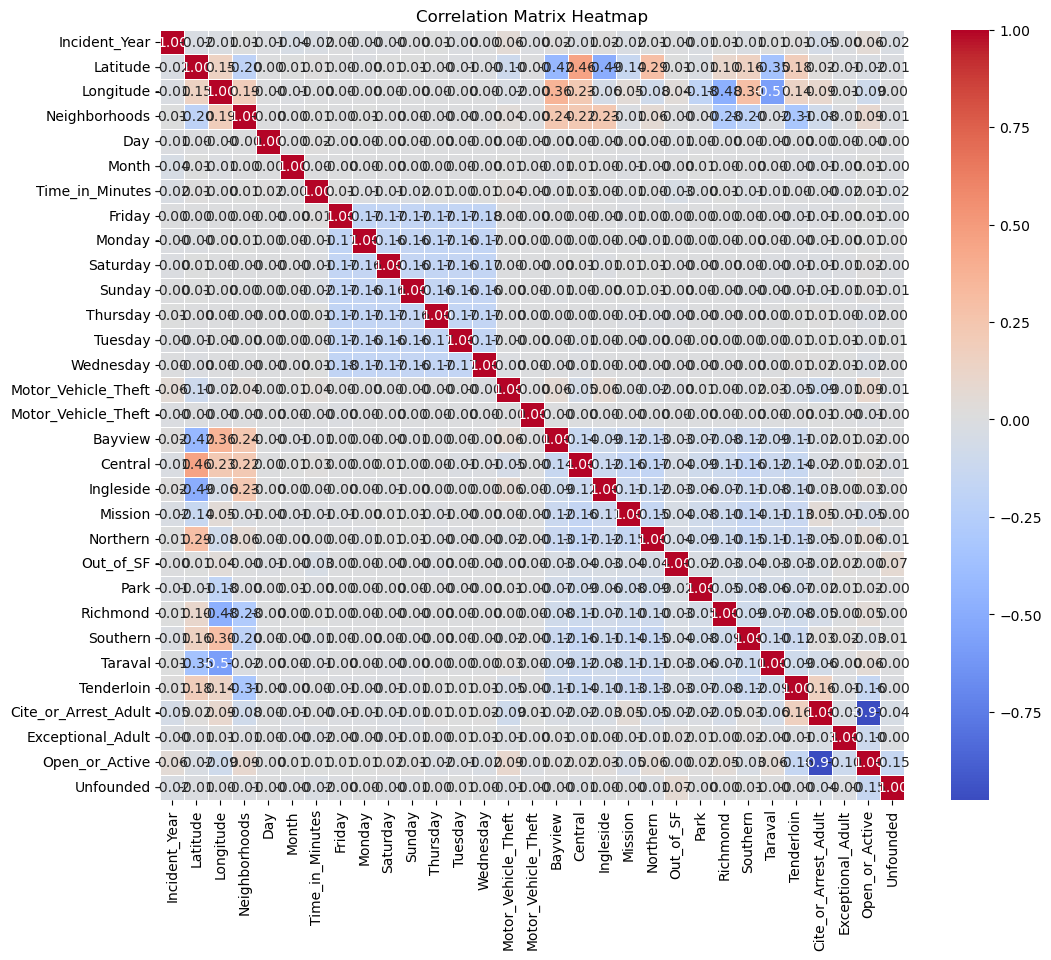

In [49]:
# Calculate the correlation matrix
corr = sf_data_train.drop(columns=one_hot_encoded_data_category).corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='coolwarm', 
            annot=True,      
            fmt=".2f",       
            linewidths=0.5)  

plt.title('Correlation Matrix Heatmap')
plt.show()


This heatmap is a bit hard to read howverr we can see that there is a strong negatie correlation between `Open_or_Active` Resolution and `Cite_or_Arrest_Adult` Resolution. This makes sense because they are opposite and come out from the same original column. Therefore they will not be helpful in our model.
We also observe very week correlation between the days of week, which also makes sense. Days of week will be a good part of the model later on. We see week correlation between the Police Districts as well -- we are going to attempt to build a more robust model by grouping by Police District.

# NAIVE BASE

In [50]:

# Assuming your DataFrame is named df
X = sf_data_train[['Incident_Year', 'Day', 'Month', 'Time_in_Minutes']]  # Include all other features here
y = sf_data_train[one_hot_encoded_data_category.columns]  # Include all crime categories here

# Initialize the Multinomial Naive Bayes classifier within OneVsRest framework
nb = OneVsRestClassifier(MultinomialNB())

# Fit the model
nb.fit(X, y)

# Now you can use nb to make predictions
probabilities = nb.predict_proba(X)

# Create an empty DataFrame for probabilities
prob_df = pd.DataFrame()

# Extract the probabilities for each category and add them to the DataFrame
for i, category in enumerate(one_hot_encoded_data_category.columns):
        prob_df[category] = probabilities[i]

# Resetting the index of your DataFrame if it has a meaningful index
prob_df = prob_df.reset_index()

# Step 1: Calculate the average probabilities per crime
avg_probabilities = prob_df.mean()

# Convert the Series to a DataFrame and reset index
avg_prob_df = avg_probabilities.reset_index()
avg_prob_df.columns = ['Crime_Type', 'Average_Probability']

# Step 2: Sort the values based on 'Average_Probability'
avg_prob_df = avg_prob_df.sort_values(by='Average_Probability', ascending=False)

# Now 'avg_prob_df' has each crime type as a row with its average probability
print(avg_prob_df)


                                   Crime_Type  Average_Probability
0                                       index            23.000000
28                        Other_Miscellaneous             0.627752
34                                Sex_Offense             0.627670
11                                Fire_Report             0.623319
41                                  Vandalism             0.623028
40                   Traffic_Violation_Arrest             0.480520
22                         Malicious_Mischief             0.471102
35                            Stolen_Property             0.440561
33                                    Robbery             0.430340
27                                      Other             0.418639
23                Miscellaneous_Investigation             0.415543
32                          Recovered_Vehicle             0.403635
4                                Case_Closure             0.402720
44                                    Warrant             0.38

In [51]:
# Assuming you have a test set named sf_data_test and your model is named 'nb'

# Prepare the test data (make sure it’s preprocessed the same way as the training data)
X_test = sf_data_test[['Incident_Year', 'Day', 'Month', 'Time_in_Minutes']]
y_test = sf_data_test[one_hot_encoded_data_category.columns]

# Make predictions on the test data
test_probabilities = nb.predict_proba(X_test)

# Create a DataFrame for the test probabilities (similar to what you did with the training data)
test_prob_df = pd.DataFrame()
for i, category in enumerate(one_hot_encoded_data_category.columns):
    test_prob_df[category] = test_probabilities[i]

y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Data: {accuracy}")


Accuracy on Test Data: 0.036094118497501555


# HEATMAP

In [52]:


#df = df[df['Incident_Year'] == 2023]
# Select only the latitude and longitude columns
heatmap_data = sf_data_train[['Latitude', 'Longitude']]


# Assuming heatmap_data dataframe has 'Latitude' and 'Longitude' columns 
lat_lons = heatmap_data[['Latitude', 'Longitude']].copy()
# Alternative with groupby and sorting
grouped = lat_lons.groupby(['Latitude','Longitude']).size()  
sorted_groups = grouped.sort_values(ascending=False)
print(sorted_groups)


jitter_scale = 0.001

# Apply jitter to the latitude and longitude
heatmap_data['Latitude'] = heatmap_data['Latitude'] + (np.random.rand(len(heatmap_data)) - 0.5) * jitter_scale
heatmap_data['Longitude'] = heatmap_data['Longitude'] + (np.random.rand(len(heatmap_data)) - 0.5) * jitter_scale

# Create a map centered around an average location from your data
map_ = folium.Map(location=[heatmap_data['Latitude'].mean(), heatmap_data['Longitude'].mean()], zoom_start=13, tiles="cartodb positron")
# Add the heatmap layer
HeatMap(data=heatmap_data.values.tolist()).add_to(map_)
# Save the map to an HTML file in an existing directory on your system
map_save_path = 'crime_heatmap.html'
map_.save(map_save_path)

Latitude   Longitude  
37.784560  -122.407337    3266
37.775161  -122.403636    2613
37.783933  -122.412595    2515
37.786410  -122.408036    2485
37.778719  -122.414741    2230
                          ... 
37.745710  -122.458657       1
37.736635  -122.494054       1
37.794314  -122.480394       1
37.780102  -122.497639       1
37.766349  -122.459931       1
Length: 6346, dtype: int64


/var/folders/l3/h56ll3s97r3bp825gbh1f4q80000gq/T/ipykernel_35111/3940078857.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data['Latitude'] = heatmap_data['Latitude'] + (np.random.rand(len(heatmap_data)) - 0.5) * jitter_scale
/var/folders/l3/h56ll3s97r3bp825gbh1f4q80000gq/T/ipykernel_35111/3940078857.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heatmap_data['Longitude'] = heatmap_data['Longitude'] + (np.random.rand(len(heatmap_data)) - 0.5) * jitter_scale


# RANDOM FOREST

In [53]:
import pandas as pd
# Assuming df is your DataFrame
df = sf_data_train  # Replace with your DataFrame variable
# Check the data types of all columns
column_types = df.dtypes
# Print data types
print(column_types)
# Check if all columns are numeric
all_numeric = all(column_types.apply(lambda x: np.issubdtype(x, np.number)))
print("Are all columns numeric?:", all_numeric)

Incident_Year             int64
Latitude                float64
Longitude               float64
Neighborhoods           float64
Day                       int64
                         ...   
Tenderloin                int64
Cite_or_Arrest_Adult      int64
Exceptional_Adult         int64
Open_or_Active            int64
Unfounded                 int64
Length: 78, dtype: object
Are all columns numeric?: True


### Cross Validation fro Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_leaf_nodes': [10, 50, 100, 500, 1000, None]  # 'None' means unlimited
}

# Initialize the classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)


#### Building Random Forest Model for only `Larceny_Theft`

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


rf_predictor_columns =['Incident_Year', 'Latitude', 'Longitude', 'Neighborhoods',
       'Month', 'Time_in_Minutes', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Motor_Vehicle_Theft',
        'Bayview', 'Central', 'Ingleside', 'Mission',
       'Northern', 'Out_of_SF', 'Park', 'Richmond', 'Southern', 'Taraval',
       'Tenderloin', 'Cite_or_Arrest_Adult', 'Exceptional_Adult',
       'Open_or_Active', 'Unfounded']
# Prepare the features (X) and target (y)
X_train = sf_data_train[rf_predictor_columns]
y_train = sf_data_train['Larceny_Theft']

X_test = sf_data_test[rf_predictor_columns]
y_test = sf_data_test['Larceny_Theft']

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_leaf_nodes=20,  # Limits the number of leaves
    n_jobs=-1             # Use all available cores
)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# to inspect feature importances
feature_importances = rf_classifier.feature_importances_


Accuracy: 0.7295358230398756
              precision    recall  f1-score   support

           0       0.73      0.98      0.84    156770
           1       0.71      0.12      0.21     64568

    accuracy                           0.73    221338
   macro avg       0.72      0.55      0.52    221338
weighted avg       0.73      0.73      0.65    221338



### Random Forest Model With All Crime Categories

In [58]:
rf_predictor_columns_multiclass =['Incident_Year', 'Day', 'Month', 'Time_in_Minutes', 'Latitude']

# Prepare the features (X) and target (y)
X_train = sf_data_train[rf_predictor_columns_multiclass]
y_train = sf_data_train[one_hot_encoded_data_category.columns]

X_test = sf_data_test[rf_predictor_columns_multiclass]
y_test = sf_data_test[one_hot_encoded_data_category.columns]

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_leaf_nodes=20,  # Limits the number of leaves because it is computationally extremely heavy
    n_jobs=-1           # Use all available cores
)

# Train the model
rf_classifier.fit(X_train, y_train)

# Initialize a dictionary to store the results
results = {}

# Iterate over each crime category to predict and evaluate
for category in one_hot_encoded_data_category.columns:
    # Predict on test data
    y_pred = rf_classifier.predict(X_test)

    # Store accuracy and classification report in the results dictionary
    accuracy = accuracy_score(y_test[category], y_pred[:, y_train.columns.get_loc(category)])
    report = classification_report(y_test[category], y_pred[:, y_train.columns.get_loc(category)])
    results[category] = {'Accuracy': accuracy, 'Report': report}

# Display results for each category
for category, metrics in results.items():
    print(f"Results for {category}:")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(metrics['Report'])
    print("\n")


/Users/MV/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/MV/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/MV/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/MV/anaconda3/lib/python3.11/si

Results for Arson:
Accuracy: 0.997153674470719
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    220708
           1       0.00      0.00      0.00       630

    accuracy                           1.00    221338
   macro avg       0.50      0.50      0.50    221338
weighted avg       0.99      1.00      1.00    221338



Results for Assault:
Accuracy: 0.9356414171990349
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    207093
           1       0.00      0.00      0.00     14245

    accuracy                           0.94    221338
   macro avg       0.47      0.50      0.48    221338
weighted avg       0.88      0.94      0.90    221338



Results for Burglary:
Accuracy: 0.9406382997948839
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    208199
           1       0.00      0.00      0.00     13139

    accuracy                  

/Users/MV/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/MV/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/MV/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
# Convert the results dictionary to a DataFrame
df_results = pd.DataFrame(results).T


df_results.head()


,Accuracy,Report
Arson,0.997154,precision recall f1-score ...
Assault,0.935641,precision recall f1-score ...
Burglary,0.940638,precision recall f1-score ...
Case_Closure,0.996029,precision recall f1-score ...
Civil_Sidewalks,0.998825,precision recall f1-score ...


In [73]:
import re
# Initialize lists to store the extracted data
categories = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Regular expression pattern to extract the metrics
pattern = r'1\s+([\d\.]+)\s+([\d\.]+)\s+([\d\.]+)'

# Iterate over the dictionary and extract the data
for category, data in results.items():
    categories.append(category)
    accuracies.append(data['Accuracy'])
    match = re.search(pattern, data['Report'])
    if match:
        precisions.append(float(match.group(1)))
        recalls.append(float(match.group(2)))
        f1_scores.append(float(match.group(3)))
    else:
        # If the pattern is not found, append NaN or a default value
        precisions.append(float('nan'))
        recalls.append(float('nan'))
        f1_scores.append(float('nan'))

# Create a DataFrame from the extracted data
df_results = pd.DataFrame({
    'Crime_Type': categories,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})
df_results

,Crime_Type,Accuracy,Precision,Recall,F1-Score
0,Arson,0.997154,0.0,0.00,0.0
1,Assault,0.935641,0.0,0.00,0.0
2,Burglary,0.940638,0.0,0.00,0.0
3,Case_Closure,0.996029,0.0,0.00,0.0
4,Civil_Sidewalks,0.998825,0.0,0.00,0.0
5,Courtesy_Report,0.996761,1.0,0.00,0.0
6,Disorderly_Conduct,0.982271,0.0,0.00,0.0
7,Drug_Offense,0.973949,0.0,0.00,0.0
8,Drug_Violation,0.999666,0.0,0.00,0.0
9,Embezzlement,0.998703,1.0,0.00,0.0


# PREDICT WHETHER THE NEXT CRIME WILL BE AN ARREST

[day of week, time of day(9pm-5am, 5am-1pm, 1pm-9pm), number arrests past 7 days, number of arrests last days, crime type dummies, neighborhood dummies] Arrest 

In [197]:
predict_arrest = df

In [198]:

# Create a new column 'Morning' based on the condition
predict_arrest['Morning'] = predict_arrest['Time_in_Minutes'].apply(lambda x: 1 if 300 < x <= 780 else 0)
# Create a new column 'Afternoon' based on the condition
predict_arrest['Afternoon'] = predict_arrest['Time_in_Minutes'].apply(lambda x: 1 if 780 < x <= 1140 else 0)
# Create a new column 'Night' based on the condition
predict_arrest['Night'] = predict_arrest['Time_in_Minutes'].apply(lambda x: 1 if 0 < x <= 300 or 1140 < x <= 1440 else 0)

Create column: `Number_Arrests_7days`

In [199]:
# Create a new column to indicate whether an incident led to an arrest
predict_arrest['Is_Arrest'] = (predict_arrest['Resolution'] == 'Cite or Arrest Adult').astype(int)

# Group by 'Incident_Date' and count the number of arrests per day
daily_arrests = predict_arrest.groupby('Incident_Date')['Is_Arrest'].sum()

# Calculate the rolling 7-day sum of arrests
rolling_arrests = daily_arrests.rolling(window=7, min_periods=1).sum()

# Map the rolling sums back to the original DataFrame
predict_arrest['Number_Arrests_7days'] = predict_arrest['Incident_Date'].map(rolling_arrests).astype(int)

Create column: `Number_Arrests_Previous_Day`

In [200]:
# Assuming 'daily_arrests' is already calculated as shown in the previous example
# Shift the 'daily_arrests' by one day to get the previous day's arrests
previous_day_arrests = daily_arrests.shift(1)

# Map the previous day's arrests back to the original DataFrame
predict_arrest['Number_Arrests_Previous_Day'] = predict_arrest['Incident_Date'].map(previous_day_arrests)

# Fill any NaN values that may have been created by the shift (e.g., for the first day in the dataset)
predict_arrest['Number_Arrests_Previous_Day'].fillna(0, inplace=True)
predict_arrest['Number_Arrests_Previous_Day'] = predict_arrest['Number_Arrests_Previous_Day'].astype(int)


In [201]:
predict_arrest

,Incident_Date,Incident_Time,Incident_Year,Incident_Day_of_Week,Incident_Category,Police_District,Latitude,Longitude,Neighborhoods,Resolution,...,Cite_or_Arrest_Adult,Exceptional_Adult,Open_or_Active,Unfounded,Morning,Afternoon,Night,Is_Arrest,Number_Arrests_7days,Number_Arrests_Previous_Day
11,2022/06/27,1900-01-01 12:00:00,2022,Monday,Lost Property,Central,37.787359,-122.408227,19.0,Open or Active,...,0,0,1,0,1,0,0,0,349,41
13,2023/03/16,1900-01-01 17:30:00,2023,Thursday,Assault,Bayview,37.762290,-122.401324,54.0,Open or Active,...,0,0,1,0,0,1,0,0,475,95
33,2023/03/21,1900-01-01 15:50:00,2023,Tuesday,Non-Criminal,Northern,37.787038,-122.418271,50.0,Open or Active,...,0,0,1,0,0,1,0,0,484,62
61,2021/08/22,1900-01-01 09:40:00,2021,Sunday,Warrant,Northern,37.793977,-122.429804,102.0,Open or Active,...,0,0,1,0,1,0,0,0,371,47
87,2022/07/02,1900-01-01 22:53:00,2022,Saturday,Assault,Bayview,37.719298,-122.390020,88.0,Open or Active,...,0,0,1,0,0,0,1,0,415,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797679,2023/03/22,1900-01-01 13:30:00,2023,Wednesday,Robbery,Mission,37.753004,-122.406336,54.0,Cite or Arrest Adult,...,1,0,0,0,0,1,0,1,460,51
797680,2023/03/22,1900-01-01 00:13:00,2023,Wednesday,Larceny Theft,Northern,37.788995,-122.440624,102.0,Cite or Arrest Adult,...,1,0,0,0,0,0,1,1,460,51
797681,2023/03/21,1900-01-01 21:19:00,2023,Tuesday,Non-Criminal,Ingleside,37.708806,-122.452665,66.0,Open or Active,...,0,0,1,0,0,0,1,0,484,62
797682,2023/03/22,1900-01-01 15:28:00,2023,Wednesday,Larceny Theft,Central,37.790565,-122.405574,19.0,Open or Active,...,0,0,1,0,0,1,0,0,460,51


In [202]:
predict_arrest[['Arson', 'Assault', 'Burglary', 'Case_Closure',
       'Civil_Sidewalks', 'Courtesy_Report', 'Disorderly_Conduct',
       'Drug_Offense', 'Drug_Violation', 'Embezzlement', 'Fire_Report',
       'Forgery_And_Counterfeiting', 'Fraud', 'Gambling', 'Homicide',
       'Human_Trafficking_A_Commercial_Sex_Acts',
       'Human_Trafficking_B_Involuntary_Servitude',
       'Human_Trafficking_Commercial_Sex_Acts', 'Larceny_Theft', 'Liquor_Laws',
       'Lost_Property', 'Malicious_Mischief', 'Miscellaneous_Investigation',
       'Missing_Person', 
      
       'NonCriminal', 'Offences_Against_The_Family_And_Children', 'Other',
       'Other_Miscellaneous', 'Other_Offenses', 'Prostitution', 'Rape',
       'Recovered_Vehicle', 'Robbery', 'Sex_Offense', 'Stolen_Property',
       'Suicide', 'Suspicious', 'Suspicious_Occ', 'Traffic_Collision',
       'Traffic_Violation_Arrest', 'Vandalism', 'Vehicle_Impounded',
       'Vehicle_Misplaced', 'Warrant', 'Weapons_Carrying_Etc',
       'Weapons_Offence', 'Weapons_Offense']].sum()

Arson                                          2208
Assault                                       47187
Burglary                                      43143
Case_Closure                                   3032
Civil_Sidewalks                                 886
Courtesy_Report                                2318
Disorderly_Conduct                            13083
Drug_Offense                                  19270
Drug_Violation                                  245
Embezzlement                                    932
Fire_Report                                    1156
Forgery_And_Counterfeiting                     2633
Fraud                                         24789
Gambling                                         32
Homicide                                        121
Human_Trafficking_A_Commercial_Sex_Acts         110
Human_Trafficking_B_Involuntary_Servitude         1
Human_Trafficking_Commercial_Sex_Acts            23
Larceny_Theft                                215606
Liquor_Laws 

In [203]:
predict_arrest = predict_arrest.drop( columns= ['Incident_Date', 'Incident_Time', 'Incident_Year',
       'Incident_Day_of_Week', 'Incident_Category', 'Police_District',

       'Neighborhoods', 'Resolution','Day',
       'Time_in_Minutes',  'Motor_Vehicle_Theft','Cite_or_Arrest_Adult', 'Exceptional_Adult',
       'Open_or_Active', 'Unfounded',
       
       ###### KEEPING COLUMNS: CRIME
       #  'Arson', 'Assault', 'Burglary', 'Case_Closure',
       # 'Civil_Sidewalks', 'Courtesy_Report', 'Disorderly_Conduct',
       # 'Drug_Offense', 'Drug_Violation', 'Embezzlement', 'Fire_Report',
       # 'Forgery_And_Counterfeiting', 'Fraud', 'Gambling', 'Homicide',
       # 'Human_Trafficking_A_Commercial_Sex_Acts',
       # 'Human_Trafficking_B_Involuntary_Servitude',
       # 'Human_Trafficking_Commercial_Sex_Acts', 'Larceny_Theft', 'Liquor_Laws',
       # 'Lost_Property', 'Malicious_Mischief', 'Miscellaneous_Investigation',
       # 'Missing_Person', 
       # 'Motor_Vehicle_Theft',
       # 'NonCriminal', 'Offences_Against_The_Family_And_Children', 'Other',
       # 'Other_Miscellaneous', 'Other_Offenses', 'Prostitution', 'Rape',
       # 'Recovered_Vehicle', 'Robbery', 'Sex_Offense', 'Stolen_Property',
       # 'Suicide', 'Suspicious', 'Suspicious_Occ', 'Traffic_Collision',
       # 'Traffic_Violation_Arrest', 'Vandalism', 'Vehicle_Impounded',
       # 'Vehicle_Misplaced', 'Warrant', 'Weapons_Carrying_Etc',
       # 'Weapons_Offence', 'Weapons_Offense', 

       ###### KEEPING COLUMNS: DISTRICT
       # 'Latitude', 'Longitude', 
       # 'Bayview', 'Central', 'Ingleside',
       # 'Mission', 'Northern', 'Out_of_SF', 'Park', 'Richmond', 'Southern',
       # 'Taraval', 'Tenderloin',

       ###### KEEPING COLUMNS: TIME FO DAY
       # 'Morning', 'Afternoon', 'Night',
       ###### KEEPING COLUMNS: ARRESTS
       # 'Is_Arrest', 'Number_Arrests_7days', 'Number_Arrests_Previous_Day'
       ])

In [204]:
predict_arrest

,Latitude,Longitude,Month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,...,Richmond,Southern,Taraval,Tenderloin,Morning,Afternoon,Night,Is_Arrest,Number_Arrests_7days,Number_Arrests_Previous_Day
11,37.787359,-122.408227,6,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,349,41
13,37.762290,-122.401324,3,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,475,95
33,37.787038,-122.418271,3,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,484,62
61,37.793977,-122.429804,8,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,371,47
87,37.719298,-122.390020,7,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,415,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797679,37.753004,-122.406336,3,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,460,51
797680,37.788995,-122.440624,3,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,460,51
797681,37.708806,-122.452665,3,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,484,62
797682,37.790565,-122.405574,3,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,460,51


In [205]:

sf_data_arrest_train, sf_data_arrest_test = train_test_split(predict_arrest, test_size=0.3, random_state=88)


## RANDOM FOREST, PREDICTION COLUMN: ARREST

In [206]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score



# Prepare the features (X) and target (y)
X_train = sf_data_arrest_train.drop(columns='Is_Arrest')
y_train = sf_data_arrest_train['Is_Arrest']

X_test = sf_data_arrest_test.drop(columns='Is_Arrest')
y_test = sf_data_arrest_test['Is_Arrest']

# Create a Random Forest Classifier
rf_classifier_arrest = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    #max_leaf_nodes=20,  # Limits the number of leaves
    n_jobs=-1             # Use all available cores
)

# Train the model
rf_classifier_arrest.fit(X_train, y_train)

# Predict on test data
y_pred_arrest = rf_classifier_arrest.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_arrest))
print(classification_report(y_test, y_pred_arrest))

# to inspect feature importances
feature_importances = rf_classifier_arrest.feature_importances_


Accuracy: 0.8951422710966938
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    177896
           1       0.81      0.61      0.69     43442

    accuracy                           0.90    221338
   macro avg       0.86      0.79      0.82    221338
weighted avg       0.89      0.90      0.89    221338



In [207]:
important_features_arrest = pd.DataFrame({'Feature' : X_train.columns, 
              'Importance score': 100*feature_importances}).round(1)

important_features_arrest.sort_values(by = 'Importance score', ascending=False)

,Feature,Importance score
1,Longitude,11.2
0,Latitude,10.8
53,Warrant,10.4
71,Number_Arrests_7days,10.3
72,Number_Arrests_Previous_Day,9.1
...,...,...
55,Weapons_Offence,0.0
24,Homicide,0.0
25,Human_Trafficking_A_Commercial_Sex_Acts,0.0
52,Vehicle_Misplaced,0.0
